In [1]:
! pip install pandas
! pip install pydicom

import glob, pylab, pandas as pd
import pydicom, numpy as np
from skimage.transform import resize



    100% |████████████████████████████████| 8.9MB 173kB/s ta 0:00:011    22% |███████▏                        | 2.0MB 2.9MB/s eta 0:00:03    28% |█████████▏                      | 2.5MB 1.6MB/s eta 0:00:05    44% |██████████████                  | 3.9MB 3.0MB/s eta 0:00:02    52% |████████████████▉               | 4.7MB 3.2MB/s eta 0:00:02    72% |███████████████████████▎        | 6.5MB 2.9MB/s eta 0:00:01
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 7.3MB 241kB/s eta 0:00:01
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


GCP Credits Request Link - RSNA.txt  stage_1_test_images.zip
note.txt			     stage_1_train_images
stage_1_detailed_class_info.csv      stage_1_train_images.zip
stage_1_sample_submission.csv	     stage_1_train_labels.csv
stage_1_test_images
25684
20
40
60
80
1     [[0.06368547418967445, 0.002521008403360928, 0...
2     [[0.053221288515405876, 0.050140056022408265, ...
3     [[0.7852541016406582, 0.7602040816326565, 0.73...
4     [[0.00392156862745098, 0.00784313725490196, 0....
5     [[0.00392156862745098, 0.00784313725490196, 0....
6     [[0.0, 0.0, 0.00392156862745098, 0.00392156862...
7     [[0.8016006402561069, 0.5607843137254942, 0.36...
8     [[0.15406162464985745, 0.04537815126050253, 0....
9     [[0.15406162464985745, 0.04537815126050253, 0....
10    [[0.10756302521008321, 0.07364945978391349, 0....
11    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
12    [[0.0, 0.002801120448180105, 0.136694677871151...
13    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
14    [[0.0, 0

(-0.5, 223.5, 223.5, -0.5)

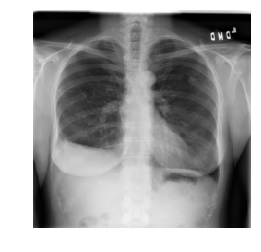

In [37]:
# Show files in data
!ls data

# display label format
df = pd.read_csv('data/stage_1_train_labels.csv')


# 
No = 4
patientId = df['patientId'][No]
dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
#print(df.iloc[No])


#print(np.unique(df.Target))
#print(df['patientId'])

img_size = [224,224]
new_df = pd.DataFrame({'Target':[],'Image':[]})
unq, idx = np.unique(df['patientId'], return_index = True)
print(len(idx))
for i in :  # len(np.unique(df['patientId']))
    new_df.Target[i] = df.Target[i]
    patientId = df['patientId'][i]
    dcm_file = 'data/stage_1_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    new_df.Image[i] = resize(dcm_data.pixel_array, output_shape=img_size, mode='reflect', anti_aliasing=True) 
    if not i % 20:
        print(i)
        
print(new_df.Image) 
    



#print(dcm_data)

#

im = new_df.Image[30]
im = resize(im, output_shape=img_size, mode='reflect', anti_aliasing=True) 
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
dcm_data. 